# Plan du notebook

0. Introduction
1. Pre-processing de la base de données diabète
2. Visualisation des données et compréhension de la biologie
3. Test des différents algorithmes de régression
4. Visualisation comparée des résultats


# 1. Pre-processing Diabete dataset

In [1]:

import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.tree import DecisionTreeRegressor as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
# Load the diabetes dataset

diabetes = datasets.load_diabetes()

# Print dataset description
print(diabetes.DESCR)





.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

# 2. Visualisation des données et compréhension de la biologie

## Sens biologique des variables

1. Age : évident
2. Sex : évident
3. BMI = IMC, doit être positivivement corrélé à la progression du diabete (type 2)
4. BP = Blood pressure
5. S1 = TC, total cholesterol 
6. S2 = ldl, le "mauvais cholesterol", qui crée des amas de graisse dans les vaisseaux sanguins quand la pression artérielle monte, lipoprotéine transportant le cholestérol dans le sang
7. S3 = hdl, le "bon cholesterol", lipoprotéine transportant le cholesterol dans le sang vers le foie 
8. S4 = tch , inconnu
9. S5 = ltg, lamorigine
10. s6 = glu, taux de glucose

## Visualisation avec pandas

In [125]:
#Create a dataframe

arr = np.append(diabetes.data, np.expand_dims(diabetes.target, axis=1), axis=1)
col = ['age', 'sex', 'body_mass_i', 'avg_blood_pressure', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'target']
df = pd.DataFrame(arr, columns=col)
print(df.corr())



                         age       sex  body_mass_i  avg_blood_pressure  \
age                 1.000000  0.173737     0.185085            0.335427   
sex                 0.173737  1.000000     0.088161            0.241013   
body_mass_i         0.185085  0.088161     1.000000            0.395415   
avg_blood_pressure  0.335427  0.241013     0.395415            1.000000   
S1                  0.260061  0.035277     0.249777            0.242470   
S2                  0.219243  0.142637     0.261170            0.185558   
S3                 -0.075181 -0.379090    -0.366811           -0.178761   
S4                  0.203841  0.332115     0.413807            0.257653   
S5                  0.270777  0.149918     0.446159            0.393478   
S6                  0.301731  0.208133     0.388680            0.390429   
target              0.187889  0.043062     0.586450            0.441484   

                          S1        S2        S3        S4        S5  \
age                 0.26006

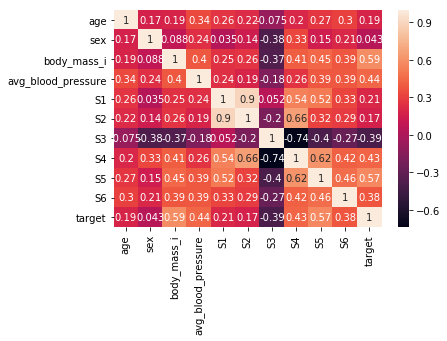

In [126]:
# Visualize the correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
corr = df.corr()
sns.heatmap(df.corr(), annot=True,)


## Interpretation de la matrice de corrélation
    
1. Tête "usuelle" d'une matrice de correlation (diagonale jaune).
2. Variables s1 et s2 très corrélées entre elles :
        -On pourrait envisager d'en enlver une sur deux/ moyenner, si on avait trop de points (optimisation temps de calcul);
        -Interprétation biologique : OK car ce sont le taux de cholestérol et le taux de hdl (mauvais cholestérol).
3. Correlation négative entre s2 et s3 : OK car le taux de hdl et ldl sont "contraires" vis à vis du tc. Mais étonnant qu'il n'y ait que peu de corrélation entre s1 et s3

As we can see, it will make sense to perform feature selection since age,sex,S1,S2 are not correlated with the target.

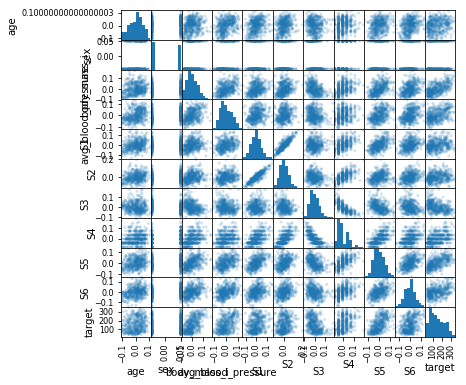

In [127]:
#Let's plot the scatter mattrix to understand better the distribution of the data.
scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='hist')
plt.show()

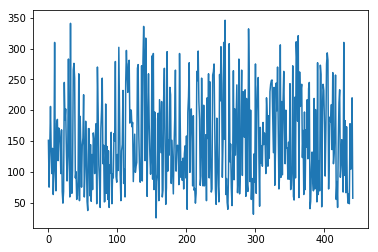

In [128]:
#on représente les valeurs de la target
plt.plot(diabetes.target[:])

## Remarques sur les données

1. Distribution gaussienne apparemment de S1 : OK.
2. S4 à un comportement particulier car seuil : Attention à notre problème de régression linéaire
3. Nous allons centrer-réduire la target, sur les données d'entraînement (pour éviter d'inclure de la donnée test dans l'entraînement)
4. Pas d'outlier visible


#On se doute à ce point qu'on pourra modifier les features pour ne garder que les plus corrélées avec la target, mais pas forcément entre elles, et dont la distribution est adéquate pour une regression.

## Principal Component Analysis:

##How many components we want in our PCa?
Let's plot the cumulative variance explained vs the number of components

Text(0, 0.5, 'cumulative explained variance')

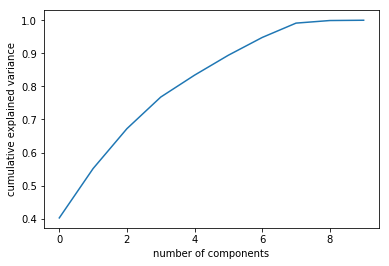

In [129]:
pca = PCA().fit(diabetes.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

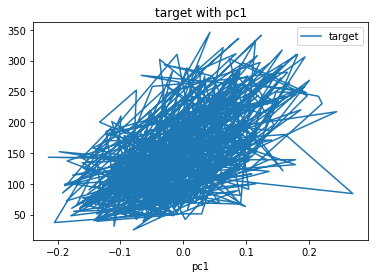

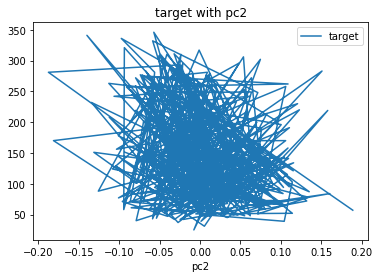

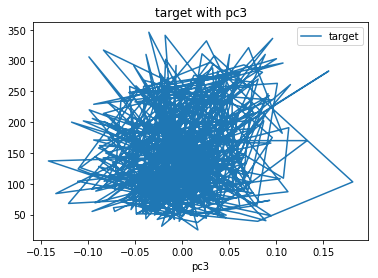

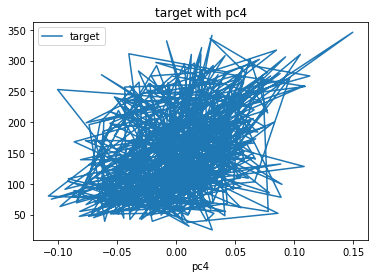

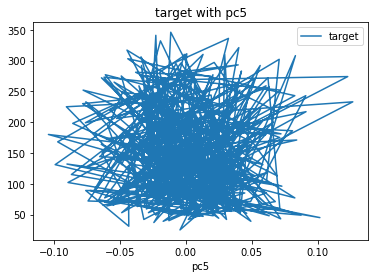

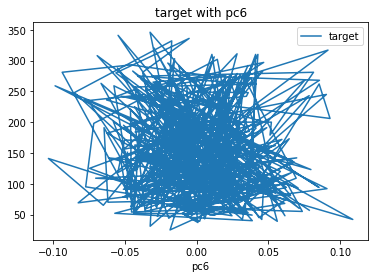

In [130]:
pca= PCA(0.89)
principalComponents = pca.fit_transform(diabetes.data)
principalDf = pd.DataFrame(data=principalComponents, columns=['pc'+str(i)for i in range(1, 7)])
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
for i in range(1,7):
    finalDf.plot(x='pc'+str(i), y='target', title= 'target with pc'+str(i))




It seems clear that the first component behave linearly with respect to the target.
For the testing part, we will test 3 different methods for all algorithms:
1) using all features
2) using features that we have identified with the correlation matrix
3) using the features given by the pca

# 3. Test des différents algorithmes de régression et comparison des résultats

In [131]:
def everything(data, param_grid,func, test_size=0.15, cv=3):
 
    clf = GridSearchCV(func, param_grid, cv=cv)
    X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    diabetes.target, test_size=test_size, random_state=42, shuffle=True)
    mean = y_train.mean()
    std = y_train.std()
    y_train = ((y_train-mean)/std)
    y_test = ((y_test-mean)/std)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    O1 = mean_squared_error(y_test, y_pred)
    O2 = clf.score(X_test,y_test)
    O3 = clf.score(X_train,y_train)
    print('Best parameters:', clf.best_params_)
    print
    print('Mean squared error on testing:', O1)
    print
    print('R squared on testing:', O2)
    print
    print('R squared on training:', O3)
    return(O1,O2,O3)

##  I) 	Baseline method: Linear Regression

### 1) All features

In [132]:
LR1 = everything(diabetes.data, param_grid=[{'fit_intercept': [True]}],func=linear_model.LinearRegression(), test_size=0.15, cv=3)


Best parameters: {'fit_intercept': True}
Mean squared error on testing: 0.5322003502400451
R squared on testing: 0.41473452102291775
R squared on training: 0.5310752027322954


### 2) Selected Features

In [133]:
df_mod = df[['body_mass_i', 'avg_blood_pressure', 'S3', 'S5']]
LR2 = everything(df_mod, param_grid=[{'fit_intercept': [True]}],
           func=linear_model.LinearRegression(), test_size=0.15, cv=3)

Best parameters: {'fit_intercept': True}
Mean squared error on testing: 0.5098908220664561
R squared on testing: 0.43926850843269505
R squared on training: 0.4983825739756891


### 3) Analyse Composante Principale

In [134]:
LR3 = everything(principalDf, param_grid=[{'fit_intercept': [True]}],
           func=linear_model.LinearRegression(), test_size=0.15, cv=3)

Best parameters: {'fit_intercept': True}
Mean squared error on testing: 0.5450666163474789
R squared on testing: 0.40058537325813826
R squared on training: 0.5230233142971703


##  II) 	Support Vector Regression

### 1) All features

In [135]:
param_grid = [{
                'kernel': ['poly', 'linear', 'rbf','sigmoid'],
                'degree': [i for i in range(1, 7)],
                'C': [i for i in range(1,10)],
                'epsilon': [0.1, 0.3 , 0.5, 1, 10],
                'gamma':['auto', 'scale']
              }]
SVR1 = everything(diabetes.data, param_grid=param_grid,
           func=SVR(), test_size=0.15, cv=3)


Best parameters: {'C': 6, 'degree': 1, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'sigmoid'}
Mean squared error on testing: 0.5260481131814866
R squared on testing: 0.42150019107036085
R squared on training: 0.5252017399699569


### 2) Selected features

In [136]:
param_grid = [{
                'kernel': ['poly', 'linear', 'rbf','sigmoid'],
                'degree': [i for i in range(1, 7)],
                'C': [i for i in range(1,10)],
                'epsilon': [0.1, 0.3 , 0.5, 1, 10],
                'gamma':['auto', 'scale']
              }]
SVR2 = everything(df_mod, param_grid=param_grid,
           func=SVR(), test_size=0.15, cv=3)

Best parameters: {'C': 8, 'degree': 1, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
Mean squared error on testing: 0.48169544997795266
R squared on testing: 0.4702752109703239
R squared on training: 0.5143491738189243


### 3) Principal Component Features

In [137]:
param_grid = [{
                'kernel': ['poly', 'linear', 'rbf','sigmoid'],
                'degree': [i for i in range(1, 7)],
                'C': [i for i in range(1,10)],
                'epsilon': [0.1, 0.3 , 0.5, 1, 10],
                'gamma':['auto', 'scale']
              }]
SVR3 = everything(principalDf, param_grid=param_grid,
           func=SVR(), test_size=0.15, cv=3)

Best parameters: {'C': 7, 'degree': 1, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'sigmoid'}
Mean squared error on testing: 0.5377820931891749
R squared on testing: 0.4085962284434861
R squared on training: 0.5206554781626516


##  III) 	Lasso Regression

### 1) All features

In [138]:
param_grid = [{'alpha': [0.0000001, 0.0000001,0.1,1]}]
LA1 = everything(diabetes.data, param_grid=param_grid,
           func=Lasso(), test_size=0.15, cv=3)


Best parameters: {'alpha': 1e-07}
Mean squared error on testing: 0.5321921278368535
R squared on testing: 0.4147435632731532
R squared on training: 0.5310752008075412


### 2) Selected features

In [139]:
param_grid = [{'alpha': [0.0000001, 0.0000001,0.1,1]}]
LA2 = everything(df_mod, param_grid=param_grid,
           func=Lasso(), test_size=0.15, cv=3)

Best parameters: {'alpha': 1e-07}
Mean squared error on testing: 0.5098909288026375
R squared on testing: 0.43926839105396276
R squared on training: 0.49838257396885743


### 3) Principal Component features

In [140]:
param_grid = [{'alpha': [0.0000001, 0.0000001,0.1,1]}]
LA3 = everything(principalDf, param_grid=param_grid,
           func=Lasso(), test_size=0.15, cv=3)

Best parameters: {'alpha': 1e-07}
Mean squared error on testing: 0.5450642537734954
R squared on testing: 0.40058797140185126
R squared on training: 0.5230233142694309


##  IV) 	Ridge Regression

### 1) All features

In [141]:
param_grid = [{'alpha': np.linspace(0.0001, 0.1, 100)}]
RG1 = everything(diabetes.data, param_grid=param_grid,
           func=Ridge(), test_size=0.15, cv=3)


Best parameters: {'alpha': 0.0011090909090909092}
Mean squared error on testing: 0.5310290487342096
R squared on testing: 0.4160226117514003
R squared on training: 0.5309912188290182


### 2) Selected features

In [142]:
param_grid = [{'alpha': np.linspace(0.0001, 0.1, 100)}]
RG2 = everything(df_mod, param_grid=param_grid,
           func=Ridge(), test_size=0.15, cv=3)



Best parameters: {'alpha': 0.057618181818181825}
Mean squared error on testing: 0.5064971832198961
R squared on testing: 0.44300052338554363
R squared on training: 0.4977609268244608


### 3) Principal Component features

In [143]:
param_grid = [{'alpha': np.linspace(0.0001, 0.1, 100)}]
RG3 = everything(principalDf, param_grid=param_grid,
           func=Ridge(), test_size=0.15, cv=3)

Best parameters: {'alpha': 0.043490909090909094}
Mean squared error on testing: 0.5397262524127188
R squared on testing: 0.4064582191793773
R squared on training: 0.5224793649454746


##  V) 	ElasticNet Regression

### 1) All features

In [144]:
param_grid = [{'alpha': np.linspace(0.00001,1,100),
               'l1_ratio': np.linspace(0.01,0.99,100)}]
EN1 = everything(diabetes.data, param_grid=param_grid,
           func=ElasticNet(), test_size=0.15, cv=3)

Best parameters: {'alpha': 1e-05, 'l1_ratio': 0.594040404040404}
Mean squared error on testing: 0.5302832379617514
R squared on testing: 0.41684278651974116
R squared on training: 0.5308742742098378


### 2) Selected features

In [145]:
param_grid = [{'alpha': np.linspace(0.00001,1,100),
               'l1_ratio': np.linspace(0.01,0.99,100)}]
EN2 = everything(df_mod, param_grid=param_grid,
           func=ElasticNet(), test_size=0.15, cv=3)

Best parameters: {'alpha': 1e-05, 'l1_ratio': 0.01}
Mean squared error on testing: 0.5096198055717893
R squared on testing: 0.43956654769270354
R squared on training: 0.49837971962918826


### 3) Principal Component features

In [146]:
param_grid = [{'alpha': np.linspace(0.00001,1,100),
               'l1_ratio': np.linspace(0.01,0.99,100)}]
EN3 = everything(principalDf, param_grid=param_grid,
           func=ElasticNet(), test_size=0.15, cv=3)

Best parameters: {'alpha': 1e-05, 'l1_ratio': 0.01}
Mean squared error on testing: 0.5445365575392537
R squared on testing: 0.4011682836642325
R squared on training: 0.5230189464433612


##  VI) 	MLP Regression

### 1) All features

In [147]:

param_grid = [{'hidden_layer_sizes': [(x,y) for x,y in zip(iter(range(50,500,50)),iter(range(50,500,50)))],
               'alpha': np.linspace(0.00001, 1, 5),
               'learning_rate': ['constant'],
               'activation':['relu'],
               'momentum':[0.5,0.9]}]
MLP1 = everything(diabetes.data, param_grid=param_grid,
           func=MLPRegressor( solver='adam',
                batch_size='auto', learning_rate_init=0.01, max_iter=1000,
                shuffle=True,random_state=42, tol=0.0001, verbose=False, warm_start=False,
               nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
               epsilon=1e-08), test_size=0.15, cv=3)


Best parameters: {'activation': 'relu', 'alpha': 0.2500075, 'hidden_layer_sizes': (450, 450), 'learning_rate': 'constant', 'momentum': 0.5}
Mean squared error on testing: 0.47703536989786105
R squared on testing: 0.4753999426600273
R squared on training: 0.5612814354118214


In [148]:
### 2) Selected features

In [149]:
param_grid = [{'hidden_layer_sizes': [(x,y) for x,y in zip(iter(range(50,500,50)),iter(range(50,500,50)))],
               'alpha': np.linspace(0.00001, 1, 5),
               'learning_rate': ['constant'],
               'activation':['relu'],
               'momentum':[0.5,0.9]}]
MLP2 = everything(df_mod, param_grid=param_grid,
           func=MLPRegressor( solver='adam',
                batch_size='auto', learning_rate_init=0.01, max_iter=1000,
                shuffle=True,random_state=42, tol=0.0001, verbose=False, warm_start=False,
               nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
               epsilon=1e-08), test_size=0.15, cv=3)

Best parameters: {'activation': 'relu', 'alpha': 0.7500025, 'hidden_layer_sizes': (450, 450), 'learning_rate': 'constant', 'momentum': 0.5}
Mean squared error on testing: 0.5002678859387594
R squared on testing: 0.44985093724808756
R squared on training: 0.4859450179667622


### 3) Principal Component features

In [150]:
param_grid = [{'hidden_layer_sizes': [(x,y) for x,y in zip(iter(range(50,500,50)),iter(range(50,500,50)))],
               'alpha': np.linspace(0.00001, 1, 5),
               'learning_rate': ['constant'],
               'activation':['relu'],
               'momentum':[0.5,0.9]}]
MLP3 = everything(principalDf, param_grid=param_grid,
           func=MLPRegressor( solver='adam',
                batch_size='auto', learning_rate_init=0.01, max_iter=1000,
                shuffle=True,random_state=42, tol=0.0001, verbose=False, warm_start=False,
               nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
               epsilon=1e-08), test_size=0.15, cv=3)

Best parameters: {'activation': 'relu', 'alpha': 0.500005, 'hidden_layer_sizes': (150, 150), 'learning_rate': 'constant', 'momentum': 0.5}
Mean squared error on testing: 0.5152056913983775
R squared on testing: 0.4334236991539251
R squared on training: 0.5352525853934376


##  VII) 	Decision Tree Regressor

### 1) All features

In [151]:
param_grid = [{
    'max_depth' : [i for i in range(1, 25, 1)],
   'min_samples_split' : [i for i in range(2, 20, 1)]
              }]
DT1 = everything(diabetes.data, param_grid=param_grid,
           func=dt(), test_size=0.15, cv=3)

Best parameters: {'max_depth': 2, 'min_samples_split': 4}
Mean squared error on testing: 0.7077909313057993
R squared on testing: 0.2216359905823413
R squared on training: 0.44906837555625045


### 2) Selected features

In [152]:
param_grid = [{
    'max_depth' : [i for i in range(1, 25, 1)],
   'min_samples_split' : [i for i in range(2, 20, 1)]}]
DT2 = everything(df_mod, param_grid=param_grid,
           func=dt(), test_size=0.15, cv=3)

Best parameters: {'max_depth': 2, 'min_samples_split': 3}
Mean squared error on testing: 0.7077909313057992
R squared on testing: 0.2216359905823414
R squared on training: 0.44906837555625057


### 3) Principal Component features

In [153]:
param_grid = [{
    'max_depth' : [i for i in range(1, 25, 1)],
   'min_samples_split' : [i for i in range(2, 20, 1)]}]
DT3 = everything(principalDf, param_grid=param_grid,
           func=dt(), test_size=0.15, cv=3)

Best parameters: {'max_depth': 3, 'min_samples_split': 19}
Mean squared error on testing: 0.6552576169676219
R squared on testing: 0.27940734560779235
R squared on training: 0.5067210996319512


##  VIII) 	Random Forest Regressor

### 1) All features

In [154]:
param_grid = [{'n_estimators':[i for i in range (2,100)],
               'max_depth':[i for i in range(1,6)],
                'min_samples_split':[2,3]}]
RF1 = everything(diabetes.data, param_grid=param_grid,
           func=RandomForestRegressor(random_state=42,), test_size=0.15, cv=3)


Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 93}
Mean squared error on testing: 0.5101457601494855
R squared on testing: 0.4389881507455825
R squared on training: 0.7291927515884905


In [155]:
### 2) Selected features

In [156]:
param_grid = [{'n_estimators':[i for i in range (2,100)],
               'max_depth':[i for i in range(1,6)],
                'min_samples_split':[2,3]}]
RF2 = everything(df_mod, param_grid=param_grid,
           func=RandomForestRegressor(random_state=42,), test_size=0.15, cv=3)


Best parameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 93}
Mean squared error on testing: 0.4938908490784108
R squared on testing: 0.4568638216455575
R squared on training: 0.5653554785024004


### 3) Principal Component features

In [157]:
param_grid = [{'n_estimators':[i for i in range (2,100)],
               'max_depth':[i for i in range(1,6)],
                'min_samples_split':[2,3]}]
RF3 = everything(principalDf, param_grid=param_grid,
           func=RandomForestRegressor(random_state=42,), test_size=0.15, cv=3)

Best parameters: {'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 22}
Mean squared error on testing: 0.4853238880812784
R squared on testing: 0.4662849851774926
R squared on training: 0.7303218846566115


##  IX) 	kNN Regressor

### 1) All features

In [158]:
param_grid = [{'n_neighbors':[i for i in range (2,30)],
               'weights':['uniform','distance']}]
knn1 = everything(diabetes.data, param_grid=param_grid,
           func=KNeighborsRegressor(), test_size=0.15, cv=3)
##Overfitting Here!!

Best parameters: {'n_neighbors': 18, 'weights': 'distance'}
Mean squared error on testing: 0.49918662720134116
R squared on testing: 0.45104000713984505
R squared on training: 1.0


### 2) Selected features

In [159]:
param_grid = [{'n_neighbors':[i for i in range (2,30)],
               'weights':['uniform','distance']}]
knn2 = everything(df_mod, param_grid=param_grid,
           func=KNeighborsRegressor(), test_size=0.15, cv=3)

Best parameters: {'n_neighbors': 27, 'weights': 'uniform'}
Mean squared error on testing: 0.4746230372625262
R squared on testing: 0.47805280640698733
R squared on training: 0.49696610373883454


### 3) Principal Component features

In [160]:
param_grid = [{'n_neighbors':[i for i in range (2,30)],
               'weights':['uniform','distance']}]
knn3 = everything(principalDf, param_grid=param_grid,
           func=KNeighborsRegressor(), test_size=0.15, cv=3)
#Overfitting!!

Best parameters: {'n_neighbors': 21, 'weights': 'distance'}
Mean squared error on testing: 0.5121508151360536
R squared on testing: 0.4367831738669318
R squared on training: 1.0


##  X) 	Gradient boost Regressor

### 1) All features

In [161]:
param_grid = [{'loss' : ['ls'],
               'learning_rate':[0.0001,0.001,0.01,0.1,1],
               'n_estimators': [i for i in range(50,500,50)],
               'min_samples_split': [2],
               'max_depth': [i for i in range(1,5)]}]
BG1 = everything(diabetes.data, param_grid=param_grid,
           func=GradientBoostingRegressor(), test_size=0.15, cv=3)


Best parameters: {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 150}
Mean squared error on testing: 0.5055678735018323
R squared on testing: 0.44402249358345003
R squared on training: 0.6143857516827027


In [162]:
### 2) Selected features


In [163]:
param_grid = [{'loss' : ['ls'],
               'learning_rate':[0.0001,0.001,0.01,0.1,1],
               'n_estimators': [i for i in range(50,500,50)],
               'min_samples_split': [2],
               'max_depth': [i for i in range(1,5)]}]
BG2 = everything(df_mod, param_grid=param_grid,
           func=GradientBoostingRegressor(), test_size=0.15, cv=3)

Best parameters: {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean squared error on testing: 0.5273903710281201
R squared on testing: 0.4200240981268548
R squared on training: 0.57357664769602


### 3) Principal Component features


In [164]:
param_grid = [{'loss' : ['ls'],
               'learning_rate':[0.0001,0.001,0.01,0.1,1],
               'n_estimators': [i for i in range(50,500,50)],
               'min_samples_split': [2],
               'max_depth': [i for i in range(1,5)]}]
BG3 = everything(principalDf, param_grid=param_grid,
           func=GradientBoostingRegressor(), test_size=0.15, cv=3)

Best parameters: {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean squared error on testing: 0.5306842210901649
R squared on testing: 0.4164018217916894
R squared on training: 0.6326162809151783


In [165]:
##  XI) 	Gaussian Process Regressor

In [166]:
### 1) All features

In [167]:
param_grid = [{'alpha' : [1e-10, 1e-8, 1e-6,1e-4,1e-2,1e-1]}]
GP1 = everything(diabetes.data, param_grid=param_grid,
           func=GaussianProcessRegressor(kernel=DotProduct()+WhiteKernel(), random_state=0), test_size=0.15, cv=3)

Best parameters: {'alpha': 0.01}
Mean squared error on testing: 0.52626653750636
R squared on testing: 0.42125998788924757
R squared on training: 0.4907467483907277


In [168]:
### 2) Selected features

In [169]:
param_grid = [{'alpha' : [1e-10, 1e-8, 1e-6,1e-4,1e-2,1e-1]}]
GP2 = everything(df_mod, param_grid=param_grid,
           func=GaussianProcessRegressor(kernel=DotProduct()+WhiteKernel(), random_state=0), test_size=0.15, cv=3)

Best parameters: {'alpha': 1e-08}
Mean squared error on testing: 0.5132685394249611
R squared on testing: 0.4355540024824772
R squared on training: 0.4689084108710775


### 3) Principal Component features

In [170]:
param_grid = [{'alpha' : [1e-10, 1e-8, 1e-6,1e-4,1e-2,1e-1]}]
GP3 = everything(principalDf, param_grid=param_grid,
           func=GaussianProcessRegressor(kernel=DotProduct()+WhiteKernel(), random_state=0), test_size=0.15, cv=3)

Best parameters: {'alpha': 0.01}
Mean squared error on testing: 0.5352018739703934
R squared on testing: 0.41143371856588995
R squared on training: 0.48847474802614055


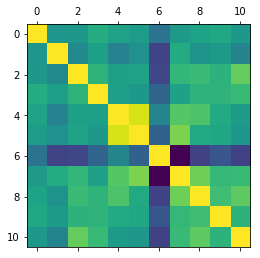

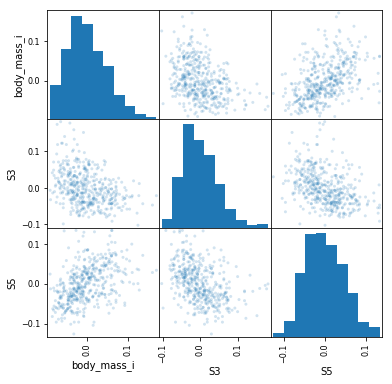

In [171]:
#print (df.head())

import warnings
warnings.simplefilter(action='ignore', category=[Warning])

df_mod = df[['body_mass_i', 'S3', 'S5']]
X_train, X_test, y_train, y_test = train_test_split(df_mod, 
                                                    diabetes.target, test_size=0.15, random_state=42, shuffle=True)

#Visualisation
from pandas.plotting import scatter_matrix
plt.matshow(df.corr())
df.corr()
scatter_matrix(df_mod, alpha = 0.2, figsize = (6, 6), diagonal = 'hist')
plt.show()

    #Modèles statistiques

# 4. Visualisation comparée des résultats

mean square error for each algorithm on the three different databases


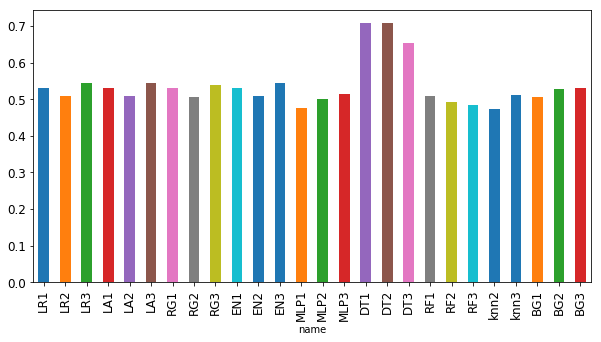


R2 on testing for each algorithm on the three different databases


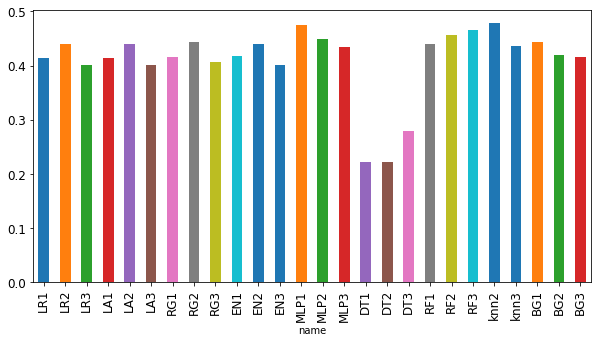


R2 on training for each algorithm on the three different databases


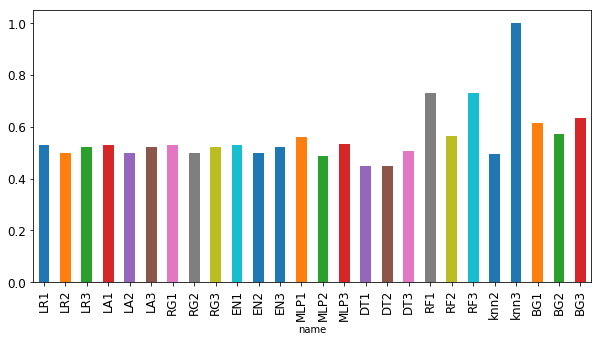

In [233]:
df_vis = pd.DataFrame([np.array(LR1), np.array(LR2), np.array(LR3),np.array(LR1), np.array(LA2), np.array(LA3), np.array(RG1),np.array(RG2),np.array(RG3),np.array(EN1),np.array(EN2),np.array(EN3), np.array(MLP1),np.array(MLP2),np.array(MLP3), np.array(DT1), np.array(DT2),np.array(DT3),np.array(RF1),np.array(RF2),np.array(RF3),np.array(knn2),np.array(knn3),np.array(BG1), np.array(BG2),np.array(BG3)])
bar_name = ['LR1','LR2','LR3','LA1','LA2','LA3','RG1','RG2','RG3','EN1','EN2','EN3','MLP1','MLP2','MLP3', 'DT1','DT2','DT3','RF1','RF2','RF3','knn2','knn3','BG1','BG2','BG3']
df_vis.insert(column="name", loc=0, value=bar_name)
df_vis.set_index("name",drop=True,inplace=True)


y_title=["mean square error", "R2 on testing", "R2 on training"]
print(y_title[0]+" for each algorithm on the three different databases")
#print(df_vis)
ax1 = df_vis[0].plot.bar(figsize=(10,5), fontsize=12)
plt.show()
print()
print(y_title[1]+" for each algorithm on the three different databases")
ax2 = df_vis[1].plot.bar(figsize=(10,5), fontsize=12)
plt.show()
print()
print(y_title[2]+" for each algorithm on the three different databases")
ax3 = df_vis[2].plot.bar(figsize=(10,5), fontsize=12)
plt.show()

# Conclusion

Nous avons tenté de prédire l'évolution du diabiète sur certains patients grâce à une dizaine de features prédéterminés. Pour cela, nous avons utilisé de nombreux algorithmes qu'on a tenté d'optimisé par GridSearch. Eliminer des features inutiles pouvant brouiller l'apprentissage des algorithmes a permis d'améliorer la performance. Cependant, nous voyons qu'aucune technique ne se distingue particulièrement sur tous les indicateurs de performance, sans overfitting (min square vers 0.5). Compte tenu de la littérature, il semble qu'on ne puisse expliquer qu'une fraction de l'évolution du diabète avec les features a disposition. Une étude de santé pourrait alors chercher à déterminer quels facteurs biologiques complémentaires pourraient être utilisé (e.g., biomarqueurs impliqués dans la dégradation de la production d'insuline).